In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.applications as models
from collections import Counter
import os
import glob
import pathlib
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
BATCH_SIZE = 8
IMG_HEIGHT, IMG_WIDTH = 299, 299

In [3]:
image_files = []
for file in glob.glob("./dataset/*"):
    image_files.append(file)
    
num_images = len(image_files)

labels_id = {}

category_type = ["mathura", "gandhara"]
depiction_type = ["buddha", "bodhisattva", "vishnu", "yakshi", "other"]
medium_type = ["red_sandstone", "phyllite", "schist", "other"]

num_type = len(category_type)
num_dep = len(depiction_type)
num_med = len(medium_type)

max_cat = max([num_type, num_dep, num_med])

with open("./labels.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            labels_id[row[0]] = [row[1], row[2], row[3]]

def get_label(file_path):
    img_id = file_path.split("/")[-1].replace(".jpg", "").replace(".JPG", "")
    _type, _depict, _medium = labels_id[img_id]
    if _medium not in medium_type:
        _medium = "other"
    if _depict not in depiction_type:
        _depict = "other"
    label = [category_type.index(_type), depiction_type.index(_depict), medium_type.index(_medium)]
    return label

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

label_list = []

for file_path in image_files:
    label = get_label(file_path)
    label_list.append(label)

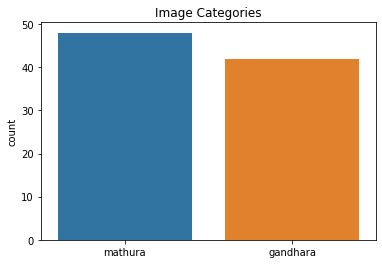

Counter({'mathura': 48, 'gandhara': 42})


In [4]:
category = [category_type[l[0]] for l in label_list]
plt.title("Image Categories")
sns.countplot(category)
plt.show()

counts = Counter()
for i in category:
    counts[i] += 1
print(counts)

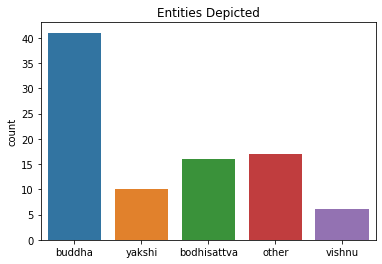

Counter({'buddha': 41, 'other': 17, 'bodhisattva': 16, 'yakshi': 10, 'vishnu': 6})


In [5]:
category = [depiction_type[l[1]] for l in label_list]
plt.title("Entities Depicted")
sns.countplot(category)
plt.show()

counts = Counter()
for i in category:
    counts[i] += 1
print(counts)

In [6]:
def zoom(x: tf.Tensor) -> tf.Tensor:
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(IMG_HEIGHT, IMG_WIDTH))
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]
    
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))
    
def process_example_train(img_path, labels):
    img = tf.io.read_file(img_path)
    img = decode_img(img)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_saturation(img, 0.6, 1.6)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.7, 1.3)
    img = zoom(img)
    img = tf.clip_by_value(img, 0.0, 1.0) - 0.5
    type_label = tf.one_hot(labels[0], max_cat)
    med_label = tf.one_hot(labels[1], max_cat)
    dep_label = tf.one_hot(labels[2], max_cat)
    return img, (type_label, med_label, dep_label)

def process_example_val(img_path, labels):
    img = tf.io.read_file(img_path)
    img = decode_img(img)
    img = tf.clip_by_value(img, 0.0, 1.0) - 0.5
    type_label = tf.one_hot(labels[0], max_cat)
    med_label = tf.one_hot(labels[1], max_cat)
    dep_label = tf.one_hot(labels[2], max_cat)
    return img, (type_label, med_label, dep_label)

num_total = len(image_files)

train_image_files, valid_image_files, train_label_list, valid_label_list = train_test_split(image_files, label_list,
                                                                                            stratify=[l[0] for l in label_list],
                                                                                            test_size=16/num_total,
                                                                                            random_state=42)

num_train = len(train_image_files)
num_valid = len(valid_image_files)

assert num_valid%8 == 0

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_label_list))
train_dataset = train_dataset.map(process_example_train, num_parallel_calls=2)
train_dataset = train_dataset.shuffle(buffer_size=100).repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=2)

val_dataset = tf.data.Dataset.from_tensor_slices((valid_image_files, valid_label_list))
val_dataset = val_dataset.map(process_example_val, num_parallel_calls=2)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=2)

In [7]:
class WarmupExpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, warmup_epochs, flat_epochs, max_epochs, epoch_steps, min_lr=1e-5, decay_exp=5, name="DecayWithWarmup"):
        super(WarmupExpDecay, self).__init__()
        self.base_lr = base_lr
        self.warmup_steps = warmup_epochs * epoch_steps
        self.flat_steps = flat_epochs * epoch_steps
        self.max_steps = (max_epochs + 1) * epoch_steps
        self.offset = self.max_steps + self.flat_steps
        self.min_lr = min_lr
        self.decay_exp = decay_exp
        self.name = name
    def __call__(self, step):
        with tf.device("/CPU:0"):
            warmup_lr = self.base_lr * step/self.warmup_steps
            flat_lr = self.base_lr
            lr = tf.math.minimum(warmup_lr, flat_lr)
            decay_lr = self.base_lr * ((self.offset-step)/self.max_steps)**self.decay_exp
            lr = tf.math.minimum(lr, decay_lr)
            return lr + self.min_lr
        
lr_schedule = WarmupExpDecay(base_lr=0.01,
                             warmup_epochs=2,
                             flat_epochs=2,
                             max_epochs=11,
                             epoch_steps=30,
                             decay_exp=2,
                             min_lr=1e-6)

In [8]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

with strategy.scope():
    input_layer = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3,), name="input_layer")
    
    base = models.MobileNetV2(input_tensor=input_layer, include_top=False, weights='imagenet')
    base.trainable = True
    base_output = base.output
    
    vis_map = layers.Conv2D(filters=3, kernel_size=(1,1))(base_output)
    vis_up = layers.Conv2D(filters=1024, kernel_size=(1,1))(vis_map)
    x = layers.GlobalAveragePooling2D()(vis_up)
    x = layers.Dropout(0.2)(x)
    
    type_pred = layers.Dense(max_cat, name="type_pred", activation="softmax")(x)
    dep_pred = layers.Dense(max_cat, name="dep_pred", activation="softmax")(x)
    med_pred = layers.Dense(max_cat, name="med_pred", activation="softmax")(x)

    model = tf.keras.models.Model(inputs=input_layer,
                                  outputs=[type_pred, dep_pred, med_pred])

    opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.01),
                  optimizer=opt,
                  metrics=["accuracy"])

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [9]:
train_steps = 30 #(num_train//BATCH_SIZE) * 2
valid_steps = (num_valid//BATCH_SIZE)

checkpoints = tf.keras.callbacks.ModelCheckpoint("./best_weights.h5", monitor='val_loss', verbose=1,
                                                 save_best_only=True, save_weights_only=True)

history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=10, verbose=2,
                    validation_data=val_dataset, validation_steps=valid_steps,
                    callbacks=[checkpoints])

Train for 30 steps, validate for 2 steps
Epoch 1/10

Epoch 00001: val_loss improved from inf to 4.27338, saving model to ./best_weights.h5
30/30 - 12s - loss: 4.5133 - type_pred_loss: 1.4213 - dep_pred_loss: 1.6015 - med_pred_loss: 1.4905 - type_pred_accuracy: 0.4542 - dep_pred_accuracy: 0.1875 - med_pred_accuracy: 0.5125 - val_loss: 4.2734 - val_type_pred_loss: 1.2774 - val_dep_pred_loss: 1.5881 - val_med_pred_loss: 1.4078 - val_type_pred_accuracy: 0.5625 - val_dep_pred_accuracy: 0.5000 - val_med_pred_accuracy: 0.5625
Epoch 2/10

Epoch 00002: val_loss improved from 4.27338 to 3.29997, saving model to ./best_weights.h5
30/30 - 3s - loss: 3.2638 - type_pred_loss: 0.8121 - dep_pred_loss: 1.4239 - med_pred_loss: 1.0279 - type_pred_accuracy: 0.5708 - dep_pred_accuracy: 0.4583 - med_pred_accuracy: 0.5917 - val_loss: 3.3000 - val_type_pred_loss: 0.8191 - val_dep_pred_loss: 1.4217 - val_med_pred_loss: 1.0592 - val_type_pred_accuracy: 0.7500 - val_dep_pred_accuracy: 0.5000 - val_med_pred_accur

In [10]:
model.load_weights("./best_weights.h5")

_, _, _, _, type_acc, dep_acc, med_acc = model.evaluate(val_dataset, steps=valid_steps, verbose=0)

print("Validation Results:")
print("Type accuracy:", int(type_acc*100), "%")
print("Entity accuracy:", int(dep_acc*100), "%")
print("Material accuracy:", int(med_acc*100), "%")

Validation Results:
Type accuracy: 87 %
Entity accuracy: 56 %
Material accuracy: 81 %


In [11]:
saliency_model = tf.keras.models.Model(inputs=input_layer,
                                       outputs=vis_map)

saliency_opacity = 0.5

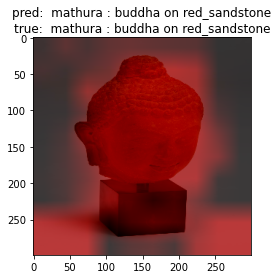

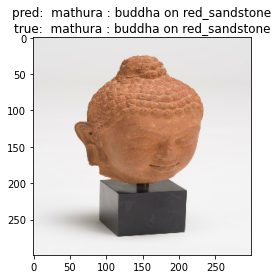

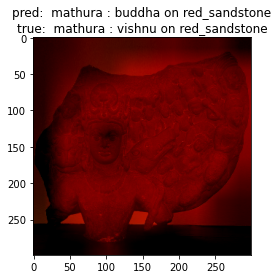

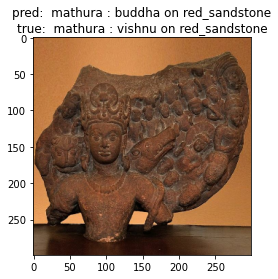

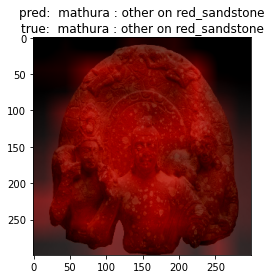

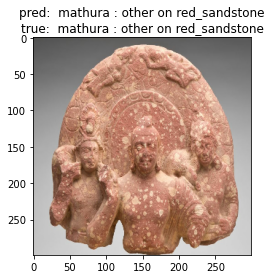

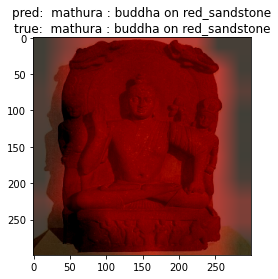

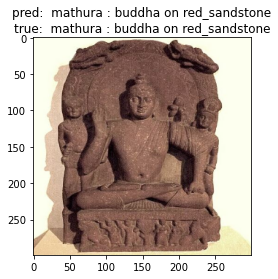

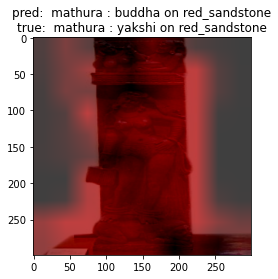

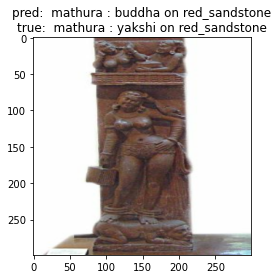

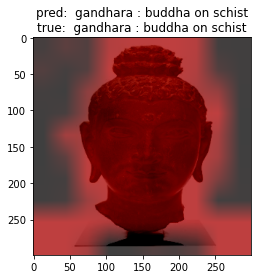

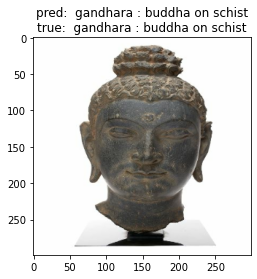

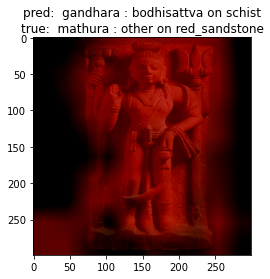

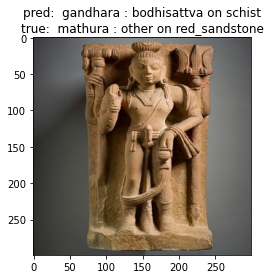

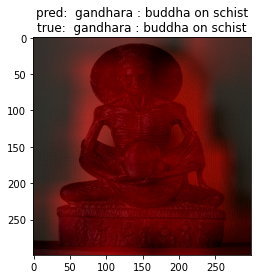

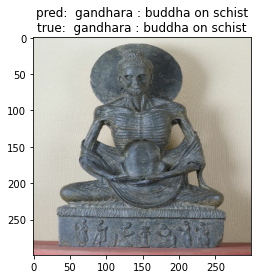

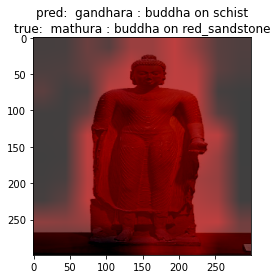

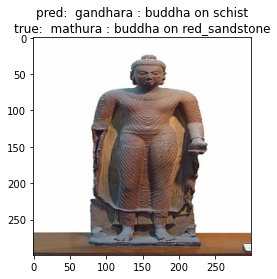

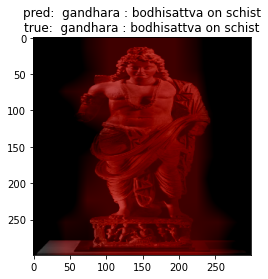

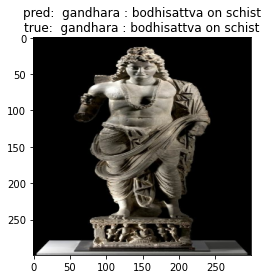

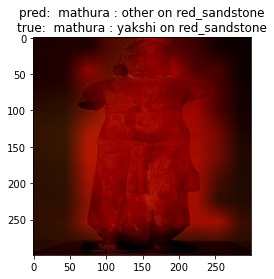

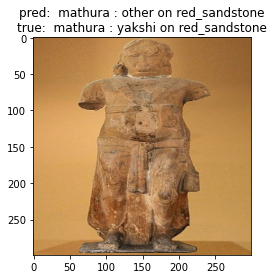

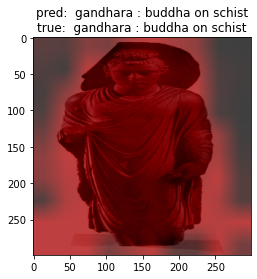

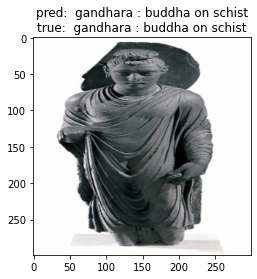

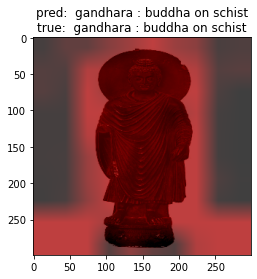

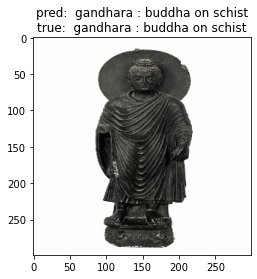

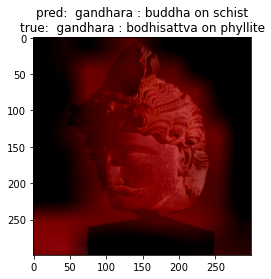

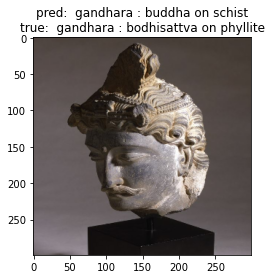

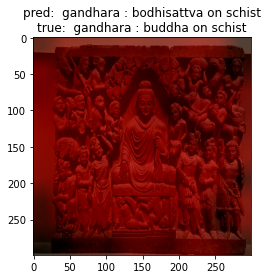

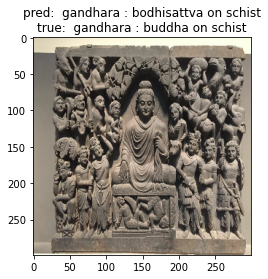

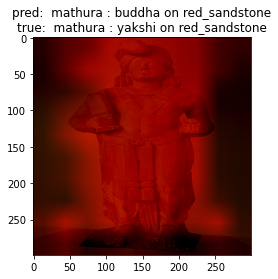

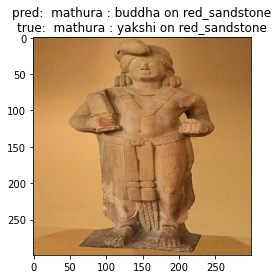

In [12]:
for batch in val_dataset.take(2):
    labels = batch[1]
    for i in range(BATCH_SIZE):
        img = batch[0][i]
        preds = model(tf.reshape(img, [1,IMG_WIDTH,IMG_HEIGHT,3]))
        smap = saliency_model(tf.reshape(img, [1,IMG_WIDTH,IMG_HEIGHT,3]))[0]
        smap = np.clip(np.asarray(smap**2, dtype="float"), 0.0, 1.0)
        smap_img = cv2.resize(smap, (IMG_WIDTH, IMG_HEIGHT))
        smap_img = cv2.cvtColor(smap_img.astype('float32'), cv2.COLOR_BGR2GRAY)
        smap_img = cv2.cvtColor(smap_img, cv2.COLOR_GRAY2BGR)
        smap_img[:,:,1] = 0
        smap_img[:,:,2] = 0
        img_with_saliency = np.clip(img*(1-saliency_opacity) + smap_img*saliency_opacity, 0.0, 1.0)
        category = category_type[np.argmax(preds[0])]
        depiction = depiction_type[np.argmax(preds[1])]
        medium = medium_type[np.argmax(preds[2])]
        title_1 = " ".join(["pred: ", category, ":", depiction, "on", medium])
        category = category_type[np.argmax(labels[0][i])]
        depiction = depiction_type[np.argmax(labels[1][i])]
        medium = medium_type[np.argmax(labels[2][i])]
        title_2 = " ".join(["true: ", category, ":", depiction, "on", medium])
        imgplot = plt.imshow(img_with_saliency)
        plt.title(title_1+"\n"+title_2)
        plt.show()
        imgplot = plt.imshow(img+0.5)
        plt.title(title_1+"\n"+title_2)
        plt.show()